# Evolved Rule


In [ ]:
#@title Downloading necessary files
# !conda install -q -y ffmpeg
!wget -q https://dl3.pushbulletusercontent.com/VvNdOmD3SRsIGnP8lCniQf3BJzX7kgRL/neighborhoods.zip
!unzip -q neighborhoods.zip
!rm -rf __MACOSX/
!rm neighborhoods.zip



In [ ]:
#@title Setting rules
rule = [[(0.451, 0.713, 0), (0.449, 0.663, 1), (0.191, 0.52, 1), (0.089, 0.296, 0)],
        [(0.332, 0.51, 0), (0.084, 0.307, 0), (0.182, 0.465, 1)],
        [(0.799, 0.902, 0), (0.303, 0.456, 0), (0.835, 0.984, 1)]]

Definition of the variables for setting the configuration

- blocksize: size of the block that is used for coarse graining. For example, block size 2 will reduce the size of grid to half, that is 100x100 grid will reduce to 50x50. These values can range from 2 to 4, in our implementation (shared parameter for rest of the known rules)

- Thresholds: List of all thresholds that are considered for visualisations such that each threshold has a horizontal line in histogram.

- width: grid size width, defalut 100 (shared parameter for rest of the known rules)

- height: grid size height, defalut 100 (shared parameter for rest of the known rules)

- steps: time steps, for which simulation of CA runs. For example, 9 steps equals to 9 frames of simulation with 9 respective updates. (shared parameter for rest of the known rules)

- initial_state_probability: The density of pixels populated initially for starting frame.

- seed_value: This value initialise the random pixels for the board as same in simulations. defalut as 1, if changed, behaviour will be different. It preserves the states, so that same pixel density could be understood for histograms and FHCG. (shared parameter for rest of the known rules)

- maximum_plot_thresh_fhcg: This value decides the limit of y-axis so as to skip extra high bars to increase the readablity of the FHCG plots. (shared parameter for rest of the known rules)


In [1]:
#@title MNCA Configuration (default is best configuration found so far at threshold 0.025)

blocksize = 2 #@param {type:"slider", min:1, max:4, step:1}
thresholds = [0.005, 0.015, 0.020, 0.022, 0.025, 0.027, 0.030, 0.033, 0.035, 0.038, 0.041, 0.044, 0.047, 0.050, 0.053, 0.056, 0.059, 0.062] #@param {type: "raw"}
# [0.005, 0.015, 0.020, 0.022, 0.025, 0.027, 0.030, 0.033, 0.035, 0.038, 0.041, 0.044, 0.047, 0.050, 0.053, 0.056, 0.059, 0.062]
width = 100 #@param {type:"slider", min:50, max:120, step:1}
height = 100 #@param {type:"slider", min:50, max:120, step:1}
steps = 9 #@param {type:"slider", min:0, max:100, step:1}
initial_state_probability = 0.06 #@param {type:"slider", min:0, max:1, step:0.01}
seed_value = 1 #@param {type: "number"}
minimum_plot_thresh_fhcg = 0
maximum_plot_thresh_fhcg = 0.1 #@param {type:"slider", min:0.1, max:0.3, step:0.01}


In [ ]:
#@title Check for width and height adjustment
# Check width, height whether divisible by 2 or 3
# Slice width and height accordingly

def adjust_dimensions(blocksize, width, height):
    if blocksize == 2:
        width = (width // 2) * 2  # Round down to the nearest multiple of 2
        height = (height // 2) * 2
    elif blocksize == 3:
        width = (width // 3) * 3  # Round down to the nearest multiple of 3
        height = (height // 3) * 3
    return width, height

width, height = adjust_dimensions(blocksize, width, height)
# print(f"Adjusted width: {width}")
# print(f"Adjusted height: {height}")
# print(f"block size: {blocksize}")


In [ ]:
#@title Generate HD gif and save array information
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from collections import Counter
import copy
# Preserving the board state, rather than saving the physical data of board states, lets just save the random seed!
# At least for 2D we can do that because, we just need to assign a known random seed and perform coarse graining over different thresholds
# testing different thresholds could be done on the same rule and board states by saving random seed and hence initialising the board with
# same initial state.
np.random.seed(seed_value)


############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
def blockshaped(arr, nrows, ncols):

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


import copy
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def FrequencyHistogramCoarseGraining(array_3d, threshold):
    time_steps, width, height = array_3d.shape

    # Let us split NxN array into smaller 2x2 blocks
    super_cells_list_volumetric = []
    new_board_volumetric_supercells_list = []
    threshold1 = threshold

    # Iterate over each 2D grid
    for grid_2d in array_3d:
        blocked_grid_2d = blockshaped(grid_2d, blocksize, blocksize)
        for each_sub_array in blocked_grid_2d:
            super_cells_list_volumetric.append(list(each_sub_array.flatten()))

    test_array = np.array(super_cells_list_volumetric)

    for i in range(len(super_cells_list_volumetric)):
        count = 0
        for j in range(len(super_cells_list_volumetric)):
            if super_cells_list_volumetric[i] == super_cells_list_volumetric[j]:
                count = count + 1
        new_board_volumetric_supercells_list.append(count / len(super_cells_list_volumetric))

    a = super_cells_list_volumetric
    total = len(a)
    freq = Counter(map(tuple, a))
    prob = {k: v / total for k, v in freq.items()}
    sorted_prob = dict(sorted(prob.items(), key=lambda x: x[0]))

    # Stylize the bar plot
    bar_color = 'steelblue'
    edge_color = 'black'
    text_color = 'black'
    grid_color = 'lightgray'
    fig, ax = plt.subplots()
    ax.bar(range(len(sorted_prob)), list(sorted_prob.values()), color=bar_color, edgecolor=edge_color)
    ax.set_xticks(range(len(sorted_prob)))
    ax.set_xticklabels([int(''.join(map(str, k)), 2) for k in sorted_prob.keys()], rotation=90)
    ax.set_xlabel('Decimal Values of the binary values in block')
    ax.set_ylabel('Probability of occurrence')
    ax.set_title('Probability of occurrence of supercells vs (Decimal Values)')
    ax.set_yticks([i / 20 for i in range(21)])
    ax.set_yticklabels([f'{i / 20:.2f}' for i in range(21)])
    ax.hlines(threshold, xmin=range(len(sorted_prob))[0], xmax=range(len(sorted_prob))[-1], colors='r', linestyles='dashed')
    ax.set_ylim(minimum_plot_thresh_fhcg, maximum_plot_thresh_fhcg)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(grid_color)
    ax.spines['left'].set_color(grid_color)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    ax.grid(color=grid_color)

    # Add annotation for threshold value
    ax.annotate(f'Threshold: {threshold}', xy=(range(len(sorted_prob))[-1], threshold), xytext=(-45, 5), textcoords='offset points', color='r')

    plt.savefig("histogram" + str(threshold) + ".svg", format='svg')
    plt.close()

    for k in range(len(new_board_volumetric_supercells_list)):
        if new_board_volumetric_supercells_list[k] < threshold1:
            new_board_volumetric_supercells_list[k] = 1
        else:
            new_board_volumetric_supercells_list[k] = 0

    modified_board = np.array(new_board_volumetric_supercells_list)
    shape = int(np.sqrt(len(new_board_volumetric_supercells_list) / time_steps))
    modified_board_return = modified_board.reshape(time_steps, shape, shape)
    return modified_board_return





############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############



def init_board(width, height, init_state):
    if init_state == "single cell in center":
        board = np.zeros((height, width), dtype=np.int)
        board[height//2, width//2] = 1
    elif init_state == "random cells with some probability":
        p = initial_state_probability # probability of a cell being alive
        board = np.random.choice([0, 1], size=(height, width), p=[1-p, p])
    elif init_state == "random cells with 2 different states":
        p1 = 0.250 # probability of a cell being state 1
        board = np.random.choice([0, 1, 2], size=(height, width), p=[1-p1, p1/2, p1/2])
    else:
        raise ValueError("Invalid initial state")
    return board

volume_board_data = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums, initial_state):
  if(frame == 0):
    img.set_data(initial_state)  # Set the initial state as the first frame
    return img,
  new_board = np.zeros_like(board, dtype=int)
  height, width = board.shape
  for i in range(height):
      for j in range(width):
          next_state = board[i, j]
          for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
              cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                    for ni, nj in neighborhood]

              # # use this for sum
              # neighborhood_sum = sum(cell_neighborhood)

              # use this for average
              neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
              for lower, upper, new_next_state in range_of_neighborhood_sum:
                  if lower <= neighborhood_sum <= upper:
                      next_state = new_next_state
          new_board[i, j] = next_state
  board[:] = new_board[:]
  # board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
  import copy
  volume_board_data.append(copy.deepcopy(board)) # Collecting boaards in a list for coarse grianing
  img.set_data(board)
  return img,

def run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums):
    board = init_board(width, height, init_state)
    initial_state = copy.deepcopy(board)  # Store the initial state separately

    fig, ax = plt.subplots()
    plt.axis('off')
    img = ax.imshow(board, cmap='binary')

    ani = animation.FuncAnimation(fig, update, frames=steps + 1,  # Add 1 to include the initial state
                                  fargs=(img, board, neighborhoods, range_of_neighborhood_sums, initial_state),
                                  repeat=False)
    ani.save(filename, writer='pillow')
    plt.close()



def extract_neighborhood_from_file(file_name):
    with open(file_name, "r") as f:
        lines = f.readlines()
        neighborhood = []
        for i, line in enumerate(lines):
            line = line.strip()
            for j, value in enumerate(line.split(" ")):
                if value == "1":
                    neighborhood.append((i-1, j-1))
        return neighborhood


init_state = "random cells with some probability"




nh1 = extract_neighborhood_from_file('neighborhoods/mask_c1.txt')
nh2 = extract_neighborhood_from_file('neighborhoods/mask_c2.txt')
nh3 = extract_neighborhood_from_file('neighborhoods/mask_c3.txt')
neighborhoods = [nh1,nh2,nh3]
range_of_neighborhood_sums=rule



filename = "animation_hd.gif"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)
import base64
from IPython.display import HTML, display

def display_gif_with_centered_caption(filename, caption):
    with open(filename, 'rb') as f:
        data = f.read()
        encoded = base64.b64encode(data).decode('ascii')
        html = f'''
        <figure style="text-align: center;">
            <img src="data:image/gif;base64,{encoded}" alt="gif" style="display: block; margin: 0 auto;">
            <figcaption style="text-align: center; margin-top: 10px;">{caption}</figcaption>
        </figure>
        '''
        display(HTML(html))

# display_gif_with_centered_caption('animation_hd.gif', 'Non Coarse Grained MNCA')




In [ ]:
#@title Converting to np array
import numpy as np
grid_array = np.array(volume_board_data)
# print(grid_array.shape)


In [ ]:
#@title Create GIF Function
from PIL import Image
import os

def create_gif(directory, output_filename):
    filenames = [f for f in os.listdir(directory) if f.endswith('.png')]
    filenames.sort(key=lambda x: int(x[:-4]))
    with Image.open(os.path.join(directory, filenames[0])) as im:
        sequence = [Image.open(os.path.join(directory, f)) for f in filenames]

        sequence[0].save(output_filename,
                         save_all=True,
                         append_images=sequence[1:],
                         duration=100,      # Duration of each frame (in ms)
                         loop=0)            # Number of loops (0 means infinite)





In [ ]:
#@title Running FHCG here
import os
for k in range(len(thresholds)):
  fhcg = FrequencyHistogramCoarseGraining(grid_array,thresholds[k])
  # print(fhcg.shape)
  for i in range(len(fhcg)):
    plt.imshow(fhcg[i],cmap="binary")
    filename = "{:04d}.png".format(i)
    plt.savefig(filename)
    plt.close()
  create_gif('.', 'animation_cg_'+str(thresholds[k])+'.gif')
  os.system("rm *.png")



In [ ]:
#@title Displaying results with zoom functionality
import base64
from IPython.display import HTML, display
import os


dir_path = './'


gif_files = [f for f in os.listdir(dir_path) if f.endswith('.gif') and f.startswith('animation_cg')]
svg_files = [f for f in os.listdir(dir_path) if f.endswith('.svg') and f.startswith('histogram')]


gif_files.sort()
svg_files.sort()


gifs = []
svgs = []
file_names = []
svg_names = []
for gif_file, svg_file in zip(gif_files, svg_files):
    gif_path = os.path.join(dir_path, gif_file)
    svg_path = os.path.join(dir_path, svg_file)

    with open(gif_path, 'rb') as f:
        gif_encoded = base64.b64encode(f.read()).decode('ascii')
    with open(svg_path, 'rb') as f:
        svg_encoded = base64.b64encode(f.read()).decode('ascii')

    file_name = gif_file.split('/')[-1]

    gifs.append(gif_encoded)
    svgs.append(svg_encoded)
    file_names.append(file_name)
    svg_names.append(svg_path.split('/')[-1])


fixed_file = 'animation_hd.gif'
fixed_file_path = os.path.join(dir_path, fixed_file)

with open(fixed_file_path, 'rb') as f:
    fixed_file_encoded = base64.b64encode(f.read()).decode('ascii')


slider = """
<style>
.slider-container {{
  display: flex;
  align-items: center;
  justify-content: center;
}}

.slider {{
  -webkit-appearance: none;
  appearance: none;
  width: 200px;
  height: 10px;
  background: #f1f1f1;
  outline: none;
  opacity: 0.7;
  -webkit-transition: .2s;
  transition: opacity .2s;
}}

.slider::-webkit-slider-thumb {{
  -webkit-appearance: none;
  appearance: none;
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}

.slider::-moz-range-thumb {{
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}
</style>

<script>
function zoomImage(event) {{
  var img = event.target;
  var posX = event.clientX;
  var posY = event.clientY;
  var rect = img.getBoundingClientRect();
  var offsetX = posX - rect.left;
  var offsetY = posY - rect.top;
  var zoomFactor = 4;
  var scale = "scale(" + zoomFactor + ")";
  var transformOrigin = offsetX + "px " + offsetY + "px";

  img.style.transform = scale;
  img.style.transformOrigin = transformOrigin;
}}

function resetImage(event) {{
  var img = event.target;
  img.style.transform = "";
  img.style.transformOrigin = "";
}}
</script>

<div class="slider-container">
  <input type="range" min="0" max="{max_val}" step="1" value="0" id="slider" class="slider">
  <p style="margin-top: 10px; font-weight: bold;" id="value_text">{value}</p>
</div>
"""

output_div = "<div id='output' style='display:flex;justify-content:center;'></div>"

script = """
<script>
var values = {values};
var fileNames = {file_names};
var svgNames = {svg_names};
var gifs = {gifs};
var svgs = {svgs};
var fixedFile = '{fixed_file}';
var fixedFileEncoded = '{fixed_file_encoded}';

function updateOutput() {{
  var slider = document.getElementById('slider');
  var output = document.getElementById('output');
  var valueText = document.getElementById('value_text');

  var selectedIndex = slider.value;
  var html = '<div style="display:flex; flex-direction:row;">' +
             '<div style="text-align:center;">' +
             '<img src="data:image/svg+xml;base64,' + svgs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + svgNames[selectedIndex] + '</p>' +
             '</div>' +
             '<div style="text-align:center;">' +
             '<img src="data:image/gif;base64,' + gifs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + fileNames[selectedIndex] + '</p>' +
             '</div>' +
             '</div>';

  var fixedHtml = '<div style="text-align:center;">' +
                  '<img src="data:image/gif;base64,' + fixedFileEncoded + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
                  '<p>' + fixedFile + '</p>' +
                  '</div>';

  output.innerHTML = html + fixedHtml;
  valueText.textContent = values[selectedIndex];
}}

var slider = document.getElementById('slider');
slider.addEventListener('input', updateOutput);
updateOutput();
</script>
"""

display(HTML(slider.format(max_val=len(gifs) - 1, value=file_names[0])))
display(HTML(output_div))

display(HTML(script.format(gifs=gifs, svgs=svgs, values=file_names, file_names=file_names, svg_names=svg_names,
                           fixed_file=fixed_file, fixed_file_encoded=fixed_file_encoded)))


# GoL

In [ ]:
#@title Setting rules
!rm *.svg
!rm *.gif
rule = [[(0, 1, 0), (3, 3, 1), (4, 8, 0)]] # GoL

In [ ]:
#@title Setting Thresholds

thresholds = [0.005,0.006,0.007, 0.008,0.009, 0.010,0.011,0.012,0.013,0.014, 0.015,0.016,0.018,0.020,0.022, 0.025, 0.04] #@param {type: "raw"}
initial_state_probability = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}


In [ ]:
#@title Cellular Automata update function for neighborhood sum rule
volume_board_data = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums, initial_state):
  if(frame == 0):
    img.set_data(initial_state)  # Set the initial state as the first frame
    return img,
  new_board = np.zeros_like(board, dtype=int)
  height, width = board.shape
  for i in range(height):
      for j in range(width):
          next_state = board[i, j]
          for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
              cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                    for ni, nj in neighborhood]

              # # use this for sum
              neighborhood_sum = sum(cell_neighborhood)

              # use this for average
              # neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
              for lower, upper, new_next_state in range_of_neighborhood_sum:
                  if lower <= neighborhood_sum <= upper:
                      next_state = new_next_state
          new_board[i, j] = next_state
  board[:] = new_board[:]
  # board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
  import copy
  volume_board_data.append(copy.deepcopy(board)) # Collecting boaards in a list for coarse grianing
  img.set_data(board)
  return img,


In [ ]:
#@title Run CA for GoL HD

nh1 = extract_neighborhood_from_file('neighborhoods/8_neighbor.txt')
neighborhoods = [nh1]
range_of_neighborhood_sums=rule
filename = "animation_hd.gif"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)
grid_array = np.array(volume_board_data)

In [ ]:
#@title Running FHCG here
import os
for k in range(len(thresholds)):
  fhcg = FrequencyHistogramCoarseGraining(grid_array,thresholds[k])
  # print(fhcg.shape)
  for i in range(len(fhcg)):
    plt.imshow(fhcg[i],cmap="binary")
    filename = "{:04d}.png".format(i)
    plt.savefig(filename)
    plt.close()
  create_gif('.', 'animation_cg_'+str(thresholds[k])+'.gif')
  os.system("rm *.png")


In [ ]:
#@title Displaying results with zoom functionality
import base64
from IPython.display import HTML, display
import os


dir_path = './'


gif_files = [f for f in os.listdir(dir_path) if f.endswith('.gif') and f.startswith('animation_cg')]
svg_files = [f for f in os.listdir(dir_path) if f.endswith('.svg') and f.startswith('histogram')]


gif_files.sort()
svg_files.sort()


gifs = []
svgs = []
file_names = []
svg_names = []
for gif_file, svg_file in zip(gif_files, svg_files):
    gif_path = os.path.join(dir_path, gif_file)
    svg_path = os.path.join(dir_path, svg_file)

    with open(gif_path, 'rb') as f:
        gif_encoded = base64.b64encode(f.read()).decode('ascii')
    with open(svg_path, 'rb') as f:
        svg_encoded = base64.b64encode(f.read()).decode('ascii')

    file_name = gif_file.split('/')[-1]

    gifs.append(gif_encoded)
    svgs.append(svg_encoded)
    file_names.append(file_name)
    svg_names.append(svg_path.split('/')[-1])


fixed_file = 'animation_hd.gif'
fixed_file_path = os.path.join(dir_path, fixed_file)

with open(fixed_file_path, 'rb') as f:
    fixed_file_encoded = base64.b64encode(f.read()).decode('ascii')


slider = """
<style>
.slider-container {{
  display: flex;
  align-items: center;
  justify-content: center;
}}

.slider {{
  -webkit-appearance: none;
  appearance: none;
  width: 200px;
  height: 10px;
  background: #f1f1f1;
  outline: none;
  opacity: 0.7;
  -webkit-transition: .2s;
  transition: opacity .2s;
}}

.slider::-webkit-slider-thumb {{
  -webkit-appearance: none;
  appearance: none;
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}

.slider::-moz-range-thumb {{
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}
</style>

<script>
function zoomImage(event) {{
  var img = event.target;
  var posX = event.clientX;
  var posY = event.clientY;
  var rect = img.getBoundingClientRect();
  var offsetX = posX - rect.left;
  var offsetY = posY - rect.top;
  var zoomFactor = 4;
  var scale = "scale(" + zoomFactor + ")";
  var transformOrigin = offsetX + "px " + offsetY + "px";

  img.style.transform = scale;
  img.style.transformOrigin = transformOrigin;
}}

function resetImage(event) {{
  var img = event.target;
  img.style.transform = "";
  img.style.transformOrigin = "";
}}
</script>

<div class="slider-container">
  <input type="range" min="0" max="{max_val}" step="1" value="0" id="slider" class="slider">
  <p style="margin-top: 10px; font-weight: bold;" id="value_text">{value}</p>
</div>
"""

output_div = "<div id='output' style='display:flex;justify-content:center;'></div>"

script = """
<script>
var values = {values};
var fileNames = {file_names};
var svgNames = {svg_names};
var gifs = {gifs};
var svgs = {svgs};
var fixedFile = '{fixed_file}';
var fixedFileEncoded = '{fixed_file_encoded}';

function updateOutput() {{
  var slider = document.getElementById('slider');
  var output = document.getElementById('output');
  var valueText = document.getElementById('value_text');

  var selectedIndex = slider.value;
  var html = '<div style="display:flex; flex-direction:row;">' +
             '<div style="text-align:center;">' +
             '<img src="data:image/svg+xml;base64,' + svgs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + svgNames[selectedIndex] + '</p>' +
             '</div>' +
             '<div style="text-align:center;">' +
             '<img src="data:image/gif;base64,' + gifs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + fileNames[selectedIndex] + '</p>' +
             '</div>' +
             '</div>';

  var fixedHtml = '<div style="text-align:center;">' +
                  '<img src="data:image/gif;base64,' + fixedFileEncoded + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
                  '<p>' + fixedFile + '</p>' +
                  '</div>';

  output.innerHTML = html + fixedHtml;
  valueText.textContent = values[selectedIndex];
}}

var slider = document.getElementById('slider');
slider.addEventListener('input', updateOutput);
updateOutput();
</script>
"""

display(HTML(slider.format(max_val=len(gifs) - 1, value=file_names[0])))
display(HTML(output_div))

display(HTML(script.format(gifs=gifs, svgs=svgs, values=file_names, file_names=file_names, svg_names=svg_names,
                           fixed_file=fixed_file, fixed_file_encoded=fixed_file_encoded)))


# High Life

In [ ]:
#@title Setting rules
!rm *.svg
!rm *.gif
rule = [[(0, 1, 0), (3, 3, 1), (6, 6, 1), (4, 8, 0)]] # GoL

In [ ]:
#@title Setting Thresholds

thresholds = [0.005,0.006,0.007, 0.008,0.009, 0.010,0.011,0.012,0.013,0.014, 0.015,0.016,0.018,0.020,0.022, 0.025,0.028,0.030,0.034, 0.037] #@param {type: "raw"}
initial_state_probability = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}


In [ ]:
#@title Cellular Automata update function for neighborhood sum rule
volume_board_data = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums, initial_state):
  if(frame == 0):
    img.set_data(initial_state)  # Set the initial state as the first frame
    return img,
  new_board = np.zeros_like(board, dtype=int)
  height, width = board.shape
  for i in range(height):
      for j in range(width):
          next_state = board[i, j]
          for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
              cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                    for ni, nj in neighborhood]

              # # use this for sum
              neighborhood_sum = sum(cell_neighborhood)

              # use this for average
              # neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
              for lower, upper, new_next_state in range_of_neighborhood_sum:
                  if lower <= neighborhood_sum <= upper:
                      next_state = new_next_state
          new_board[i, j] = next_state
  board[:] = new_board[:]
  # board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
  import copy
  volume_board_data.append(copy.deepcopy(board)) # Collecting boaards in a list for coarse grianing
  img.set_data(board)
  return img,


In [ ]:
#@title Run CA for High Life HD

nh1 = extract_neighborhood_from_file('neighborhoods/8_neighbor.txt')
neighborhoods = [nh1]
range_of_neighborhood_sums=rule
filename = "animation_hd.gif"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)
grid_array = np.array(volume_board_data)

In [ ]:
#@title Running FHCG here
import os
for k in range(len(thresholds)):
  fhcg = FrequencyHistogramCoarseGraining(grid_array,thresholds[k])
  # print(fhcg.shape)
  for i in range(len(fhcg)):
    plt.imshow(fhcg[i],cmap="binary")
    filename = "{:04d}.png".format(i)
    plt.savefig(filename)
    plt.close()
  create_gif('.', 'animation_cg_'+str(thresholds[k])+'.gif')
  os.system("rm *.png")


In [ ]:
#@title Displaying results with zoom functionality
import base64
from IPython.display import HTML, display
import os


dir_path = './'


gif_files = [f for f in os.listdir(dir_path) if f.endswith('.gif') and f.startswith('animation_cg')]
svg_files = [f for f in os.listdir(dir_path) if f.endswith('.svg') and f.startswith('histogram')]


gif_files.sort()
svg_files.sort()


gifs = []
svgs = []
file_names = []
svg_names = []
for gif_file, svg_file in zip(gif_files, svg_files):
    gif_path = os.path.join(dir_path, gif_file)
    svg_path = os.path.join(dir_path, svg_file)

    with open(gif_path, 'rb') as f:
        gif_encoded = base64.b64encode(f.read()).decode('ascii')
    with open(svg_path, 'rb') as f:
        svg_encoded = base64.b64encode(f.read()).decode('ascii')

    file_name = gif_file.split('/')[-1]

    gifs.append(gif_encoded)
    svgs.append(svg_encoded)
    file_names.append(file_name)
    svg_names.append(svg_path.split('/')[-1])


fixed_file = 'animation_hd.gif'
fixed_file_path = os.path.join(dir_path, fixed_file)

with open(fixed_file_path, 'rb') as f:
    fixed_file_encoded = base64.b64encode(f.read()).decode('ascii')


slider = """
<style>
.slider-container {{
  display: flex;
  align-items: center;
  justify-content: center;
}}

.slider {{
  -webkit-appearance: none;
  appearance: none;
  width: 200px;
  height: 10px;
  background: #f1f1f1;
  outline: none;
  opacity: 0.7;
  -webkit-transition: .2s;
  transition: opacity .2s;
}}

.slider::-webkit-slider-thumb {{
  -webkit-appearance: none;
  appearance: none;
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}

.slider::-moz-range-thumb {{
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}
</style>

<script>
function zoomImage(event) {{
  var img = event.target;
  var posX = event.clientX;
  var posY = event.clientY;
  var rect = img.getBoundingClientRect();
  var offsetX = posX - rect.left;
  var offsetY = posY - rect.top;
  var zoomFactor = 4;
  var scale = "scale(" + zoomFactor + ")";
  var transformOrigin = offsetX + "px " + offsetY + "px";

  img.style.transform = scale;
  img.style.transformOrigin = transformOrigin;
}}

function resetImage(event) {{
  var img = event.target;
  img.style.transform = "";
  img.style.transformOrigin = "";
}}
</script>

<div class="slider-container">
  <input type="range" min="0" max="{max_val}" step="1" value="0" id="slider" class="slider">
  <p style="margin-top: 10px; font-weight: bold;" id="value_text">{value}</p>
</div>
"""

output_div = "<div id='output' style='display:flex;justify-content:center;'></div>"

script = """
<script>
var values = {values};
var fileNames = {file_names};
var svgNames = {svg_names};
var gifs = {gifs};
var svgs = {svgs};
var fixedFile = '{fixed_file}';
var fixedFileEncoded = '{fixed_file_encoded}';

function updateOutput() {{
  var slider = document.getElementById('slider');
  var output = document.getElementById('output');
  var valueText = document.getElementById('value_text');

  var selectedIndex = slider.value;
  var html = '<div style="display:flex; flex-direction:row;">' +
             '<div style="text-align:center;">' +
             '<img src="data:image/svg+xml;base64,' + svgs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + svgNames[selectedIndex] + '</p>' +
             '</div>' +
             '<div style="text-align:center;">' +
             '<img src="data:image/gif;base64,' + gifs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + fileNames[selectedIndex] + '</p>' +
             '</div>' +
             '</div>';

  var fixedHtml = '<div style="text-align:center;">' +
                  '<img src="data:image/gif;base64,' + fixedFileEncoded + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
                  '<p>' + fixedFile + '</p>' +
                  '</div>';

  output.innerHTML = html + fixedHtml;
  valueText.textContent = values[selectedIndex];
}}

var slider = document.getElementById('slider');
slider.addEventListener('input', updateOutput);
updateOutput();
</script>
"""

display(HTML(slider.format(max_val=len(gifs) - 1, value=file_names[0])))
display(HTML(output_div))

display(HTML(script.format(gifs=gifs, svgs=svgs, values=file_names, file_names=file_names, svg_names=svg_names,
                           fixed_file=fixed_file, fixed_file_encoded=fixed_file_encoded)))


# Larger than Life

In [ ]:
#@title Setting rules
!rm *.svg
!rm *.gif
rule = [[(0, 33, 0), (34, 45, 1), (58, 121, 0)]] # Larger Than Life Slackermanz

In [ ]:
#@title Setting Thresholds

thresholds = [0.0007,0.0008,0.0009,0.001,0.002,0.003,0.004,0.005] #@param {type: "raw"}
initial_state_probability = 0.53 #@param {type:"slider", min:0, max:1, step:0.01}


In [ ]:
#@title Cellular Automata update function for neighborhood sum rule
volume_board_data = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums, initial_state):
  if(frame == 0):
    img.set_data(initial_state)  # Set the initial state as the first frame
    return img,
  new_board = np.zeros_like(board, dtype=int)
  height, width = board.shape
  for i in range(height):
      for j in range(width):
          next_state = board[i, j]
          for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
              cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                    for ni, nj in neighborhood]

              # # use this for sum
              neighborhood_sum = sum(cell_neighborhood)

              # use this for average
              # neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
              for lower, upper, new_next_state in range_of_neighborhood_sum:
                  if lower <= neighborhood_sum <= upper:
                      next_state = new_next_state
          new_board[i, j] = next_state
  board[:] = new_board[:]
  # board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
  import copy
  volume_board_data.append(copy.deepcopy(board)) # Collecting boaards in a list for coarse grianing
  img.set_data(board)
  return img,


In [ ]:
#@title Run CA for High Life HD

nh1 = extract_neighborhood_from_file('neighborhoods/11x11_larger_than_life.txt')
neighborhoods = [nh1]
range_of_neighborhood_sums=rule
filename = "animation_hd.gif"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)
grid_array = np.array(volume_board_data)

In [ ]:
#@title Running FHCG here
import os
for k in range(len(thresholds)):
  fhcg = FrequencyHistogramCoarseGraining(grid_array,thresholds[k])
  # print(fhcg.shape)
  for i in range(len(fhcg)):
    plt.imshow(fhcg[i],cmap="binary")
    filename = "{:04d}.png".format(i)
    plt.savefig(filename)
    plt.close()
  create_gif('.', 'animation_cg_'+str(thresholds[k])+'.gif')
  os.system("rm *.png")


In [ ]:
#@title Displaying results with zoom functionality
import base64
from IPython.display import HTML, display
import os


dir_path = './'


gif_files = [f for f in os.listdir(dir_path) if f.endswith('.gif') and f.startswith('animation_cg')]
svg_files = [f for f in os.listdir(dir_path) if f.endswith('.svg') and f.startswith('histogram')]


gif_files.sort()
svg_files.sort()


gifs = []
svgs = []
file_names = []
svg_names = []
for gif_file, svg_file in zip(gif_files, svg_files):
    gif_path = os.path.join(dir_path, gif_file)
    svg_path = os.path.join(dir_path, svg_file)

    with open(gif_path, 'rb') as f:
        gif_encoded = base64.b64encode(f.read()).decode('ascii')
    with open(svg_path, 'rb') as f:
        svg_encoded = base64.b64encode(f.read()).decode('ascii')

    file_name = gif_file.split('/')[-1]

    gifs.append(gif_encoded)
    svgs.append(svg_encoded)
    file_names.append(file_name)
    svg_names.append(svg_path.split('/')[-1])


fixed_file = 'animation_hd.gif'
fixed_file_path = os.path.join(dir_path, fixed_file)

with open(fixed_file_path, 'rb') as f:
    fixed_file_encoded = base64.b64encode(f.read()).decode('ascii')


slider = """
<style>
.slider-container {{
  display: flex;
  align-items: center;
  justify-content: center;
}}

.slider {{
  -webkit-appearance: none;
  appearance: none;
  width: 200px;
  height: 10px;
  background: #f1f1f1;
  outline: none;
  opacity: 0.7;
  -webkit-transition: .2s;
  transition: opacity .2s;
}}

.slider::-webkit-slider-thumb {{
  -webkit-appearance: none;
  appearance: none;
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}

.slider::-moz-range-thumb {{
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}
</style>

<script>
function zoomImage(event) {{
  var img = event.target;
  var posX = event.clientX;
  var posY = event.clientY;
  var rect = img.getBoundingClientRect();
  var offsetX = posX - rect.left;
  var offsetY = posY - rect.top;
  var zoomFactor = 4;
  var scale = "scale(" + zoomFactor + ")";
  var transformOrigin = offsetX + "px " + offsetY + "px";

  img.style.transform = scale;
  img.style.transformOrigin = transformOrigin;
}}

function resetImage(event) {{
  var img = event.target;
  img.style.transform = "";
  img.style.transformOrigin = "";
}}
</script>

<div class="slider-container">
  <input type="range" min="0" max="{max_val}" step="1" value="0" id="slider" class="slider">
  <p style="margin-top: 10px; font-weight: bold;" id="value_text">{value}</p>
</div>
"""

output_div = "<div id='output' style='display:flex;justify-content:center;'></div>"

script = """
<script>
var values = {values};
var fileNames = {file_names};
var svgNames = {svg_names};
var gifs = {gifs};
var svgs = {svgs};
var fixedFile = '{fixed_file}';
var fixedFileEncoded = '{fixed_file_encoded}';

function updateOutput() {{
  var slider = document.getElementById('slider');
  var output = document.getElementById('output');
  var valueText = document.getElementById('value_text');

  var selectedIndex = slider.value;
  var html = '<div style="display:flex; flex-direction:row;">' +
             '<div style="text-align:center;">' +
             '<img src="data:image/svg+xml;base64,' + svgs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + svgNames[selectedIndex] + '</p>' +
             '</div>' +
             '<div style="text-align:center;">' +
             '<img src="data:image/gif;base64,' + gifs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + fileNames[selectedIndex] + '</p>' +
             '</div>' +
             '</div>';

  var fixedHtml = '<div style="text-align:center;">' +
                  '<img src="data:image/gif;base64,' + fixedFileEncoded + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
                  '<p>' + fixedFile + '</p>' +
                  '</div>';

  output.innerHTML = html + fixedHtml;
  valueText.textContent = values[selectedIndex];
}}

var slider = document.getElementById('slider');
slider.addEventListener('input', updateOutput);
updateOutput();
</script>
"""

display(HTML(slider.format(max_val=len(gifs) - 1, value=file_names[0])))
display(HTML(output_div))

display(HTML(script.format(gifs=gifs, svgs=svgs, values=file_names, file_names=file_names, svg_names=svg_names,
                           fixed_file=fixed_file, fixed_file_encoded=fixed_file_encoded)))


In [ ]:
#@title Clearing memory
!rm *.svg
!rm *.gif

# Part 1 finished

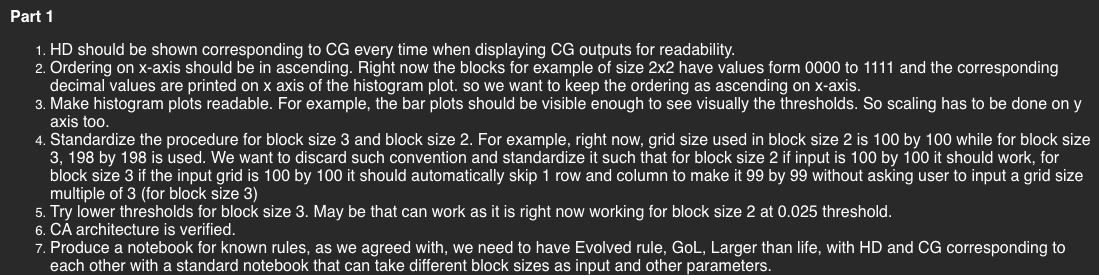